In [1]:
import pandas as pd
df = pd.read_csv('creditcard.csv', index_col=None)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import numpy as np
import tensorflow as tf
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']
X.shape , y.shape

((284807, 30), (284807,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                   random_state = 0,
                                                   stratify = y)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
# We have to reshape into a 3Dimensional object the X_train and X_test
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_test.shape

((227845, 30, 1), (56962, 30, 1))

In [9]:
epochs = 10
model = Sequential()
model.add(Conv1D(32, 128, activation='relu', dilation_rate=1, input_shape = X_train[0].shape, padding='causal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(64, 128, activation='relu', dilation_rate=2, padding='causal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(64, 128, activation='relu', dilation_rate=4, padding='causal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(64, 128, activation='relu', dilation_rate=8, padding='causal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            4128      
                                                                 
 batch_normalization (BatchN  (None, 30, 32)           128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            262208    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=matthews_correlation_coefficient)

C:\Users\lingl\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history = model.fit(X_train, y_train, epochs = epochs, validation_data=(X_test, y_test), batch_size=64, verbose=1)

Epoch 1/10
3561/3561 [==============================] - 4824s 1s/step - loss: 0.0165 - matthews_correlation_coefficient: 0.0307 - val_loss: 0.0049 - val_matthews_correlation_coefficient: 0.0682
Epoch 2/10
3561/3561 [==============================] - 10191s 3s/step - loss: 0.0051 - matthews_correlation_coefficient: 0.0601 - val_loss: 0.0050 - val_matthews_correlation_coefficient: 0.0708
Epoch 3/10
3561/3561 [==============================] - 13798s 4s/step - loss: 0.0047 - matthews_correlation_coefficient: 0.0696 - val_loss: 0.0044 - val_matthews_correlation_coefficient: 0.0719
Epoch 4/10
3561/3561 [==============================] - 5685s 2s/step - loss: 0.0046 - matthews_correlation_coefficient: 0.0717 - val_loss: 0.0045 - val_matthews_correlation_coefficient: 0.0803
Epoch 5/10
3561/3561 [==============================] - 4935s 1s/step - loss: 0.0044 - matthews_correlation_coefficient: 0.0757 - val_loss: 0.0041 - val_matthews_correlation_coefficient: 0.0792
Epoch 6/10
3561/3561 [======

In [13]:
preds = model.predict(X_test)
y_pred = np.round(preds)

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.74      0.79        98

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [15]:
from sklearn.metrics import matthews_corrcoef
print(matthews_corrcoef(y_test, y_pred))

0.7948432084342468


In [16]:
from sklearn.metrics import confusion_matrix
class Visualization:
    labels = ["No-Fraud", "Fraud"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Fraud")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

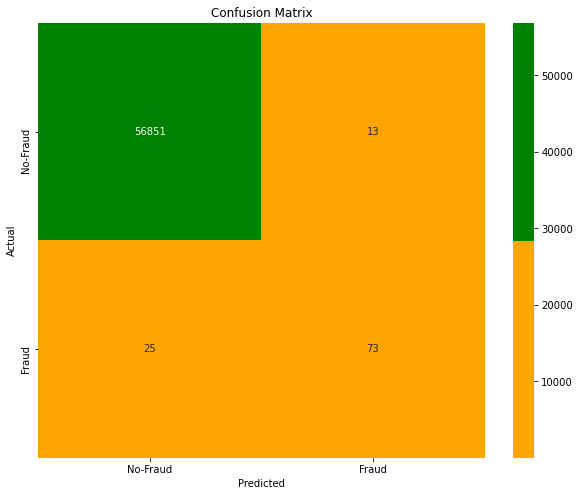

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
visualize = Visualization()
visualize.draw_confusion_matrix(y_test, y_pred)